In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from scipy.cluster import hierarchy
from skimage import io
from collections import defaultdict
import numpy as np
import superpixels as sp
import plot as pl
import process_ground_truth as pgt
import glob
import eval_boundary as ev
import pipeline as pipe
import time

In [21]:
ground_path = 'BSDS500/data/groundTruth/train/'
train_path = 'BSDS500/data/images/train/'
save_path = 'save/'
bound_prefix = save_path + 'bound_'
eval_prefix = save_path + 'precision_'
extension = '.npz'

### Load images

In [54]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

images = []
groundtruths = []

ini = 0
fim = len(ground_filenames)

#load images
for filename in ground_filenames[ini:fim]:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    #read groundtruth and image
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    #append image and groundtruths
    groundtruths.append(groundtruth)
    images.append(image)

### Generate boundaries and save results

In [57]:
methods = ['sgb', 'egb', 'slic']

for method in methods:
    boundname = bound_prefix + method + extension

    borders = []
    last_shape = None
    img = None
    
    starttime = time.time()
    for groundtruth, image in zip(groundtruths[ini:fim], images[ini:fim]):
        if(method != 'sgb'):
            if(image.shape != last_shape):
                img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
                img.fill(255)
                last_shape = image.shape

        border = pipe.generate_boundaries(image = image, blank_image = img, method = method)
        borders.append(border)

    endtime = time.time()
        
    np.savez(boundname, borders=borders)
    print(boundname)
    print((endtime - starttime), 'seconds')

save/bound_sgb.npz
510.8683831691742
save/bound_egb.npz
73.39172267913818
save/bound_slic.npz
77.63549733161926


### Recover boundaries and evaluate results

In [59]:
methods = ['sgb', 'egb', 'slic']

for method in methods:
    boundname = bound_prefix + method + extension
    evalname = eval_prefix + method + extension

    #load bound file
    npload = np.load(boundname)
    boundaries = npload['borders']

    #start precision method
    precisions, recalls = [], []
    threshold = 0

    starttime = time.time()
    for groundtruth, border in zip(groundtruths[ini:fim], boundaries):
        precision, recall = ev.eval_bound(groundtruth, border, threshold, True)    

        precisions.append(precision)
        recalls.append(recall)

    endtime = time.time()
    
    #save precision file
    np.savez(evalname, precisions=precisions, recalls=recalls)
    print(evalname)
    print((endtime - starttime), 'seconds')

save/precision_sgb.npz
77.95107436180115  seconds
save/precision_egb.npz
103.25935912132263  seconds
save/precision_slic.npz
106.47794103622437  seconds


### Load evaluations and calculate f-measures

In [60]:
methods = ['sgb', 'egb', 'slic']
fmeasures = []

for method in methods:
    evalname = eval_prefix + method + extension

    #load bound file
    npload = np.load(evalname)
    precisions = npload['precisions']
    recalls = npload['recalls']

    np_precisions = (np.array(precisions))
    np_recalls = (np.array(recalls))

    fmeasure = 2 * ((np_precisions * np_recalls) / (np_precisions + np_recalls))
    
    fmeasures.append(fmeasure)

### Plot curve

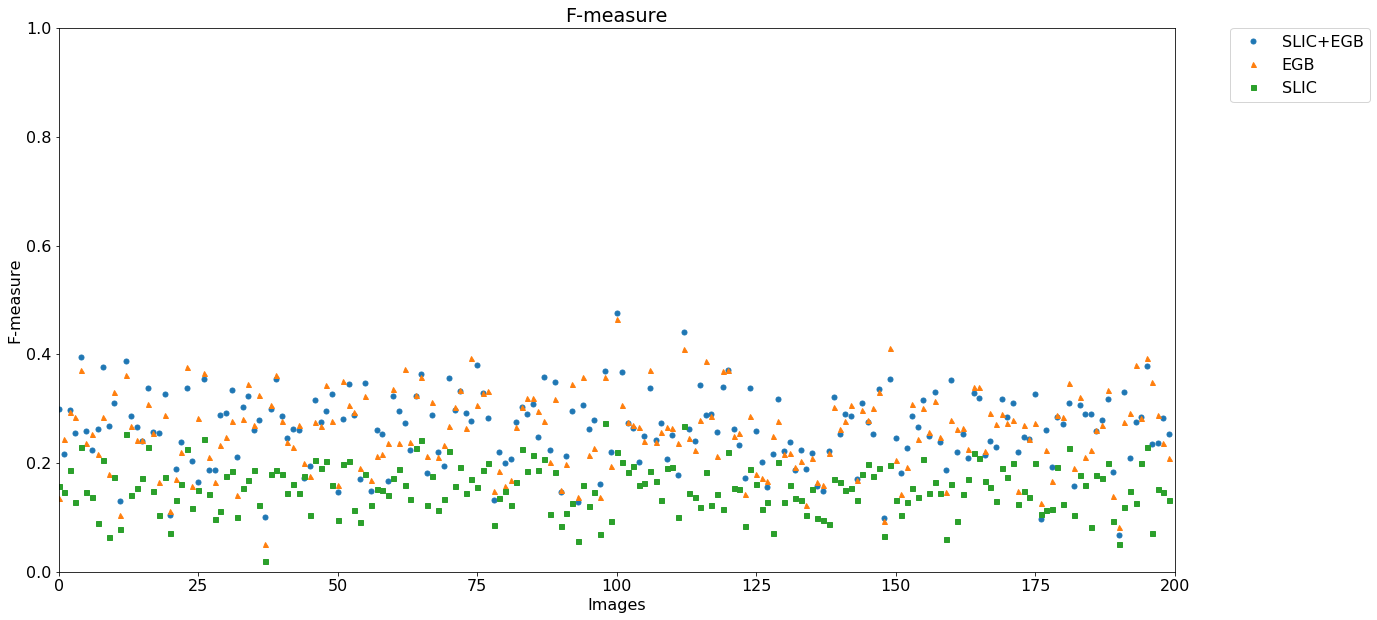

In [76]:
itens = len(fmeasures[0])

#plot curves
plt.figure(figsize=(20,10))

plt.plot(fmeasures[0], label='SLIC+EGB', marker='o', markersize=5, linewidth=0)
plt.plot(fmeasures[1], label='EGB', marker='^', markersize=5, linewidth=0)
plt.plot(fmeasures[2], label='SLIC', marker='s', markersize=5, linewidth=0)

plt.rcParams["font.size"] = 16
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis([0, itens, 0, 1])

plt.xlabel('Images')
plt.ylabel('F-measure')
plt.title('F-measure')
plt.show()

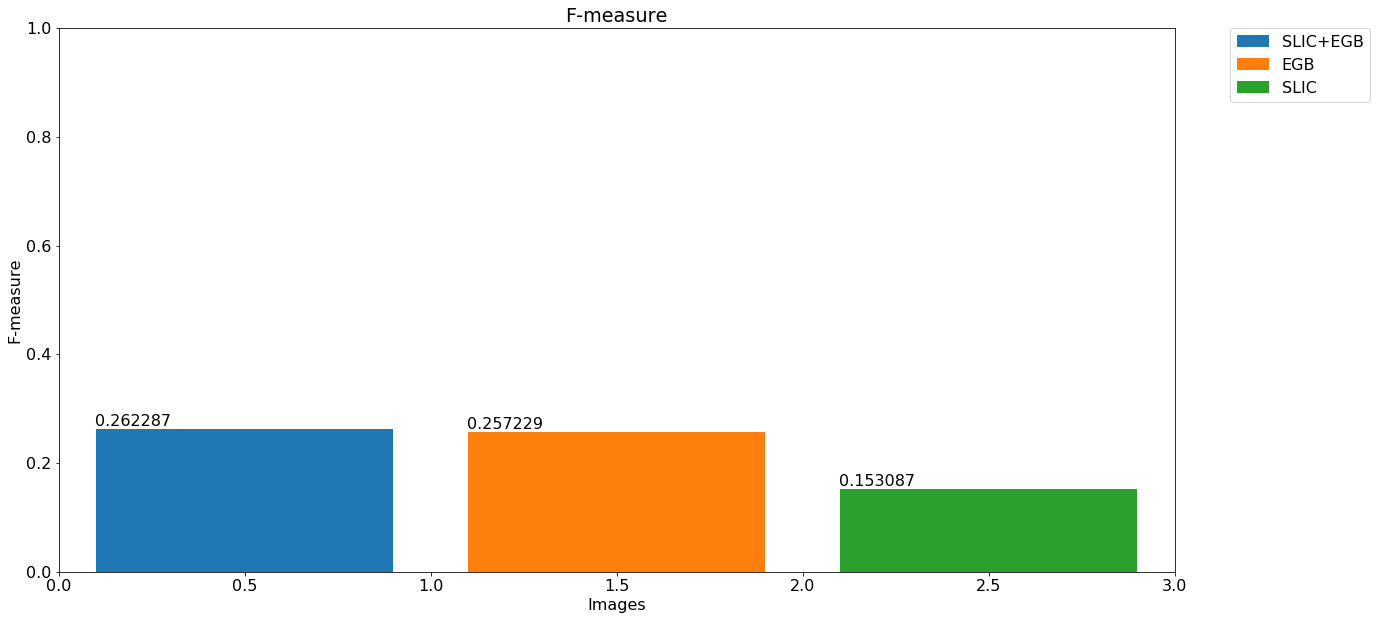

In [98]:
itens = len(fmeasures[0])

#plot curves
plt.figure(figsize=(20,10))

bar1 = plt.bar(0.5, np.average(fmeasures[0]), label='SLIC+EGB') #, marker='o', markersize=5, linewidth=0)
bar2 = plt.bar(1.5, np.average(fmeasures[1]), label='EGB') #, marker='^', markersize=5, linewidth=0)
bar3 = plt.bar(2.5, np.average(fmeasures[2]), label='SLIC') #, marker='s', markersize=5, linewidth=0)

plt.rcParams["font.size"] = 16
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis([0, 3, 0, 1])

for rect in bar1 + bar2 + bar3:
    height = rect.get_height()
    plt.text(rect.get_x()+0.1, height, '%2f' % height, ha='center', va='bottom')


plt.xlabel('Images')
plt.ylabel('F-measure')
plt.title('F-measure')
plt.show()

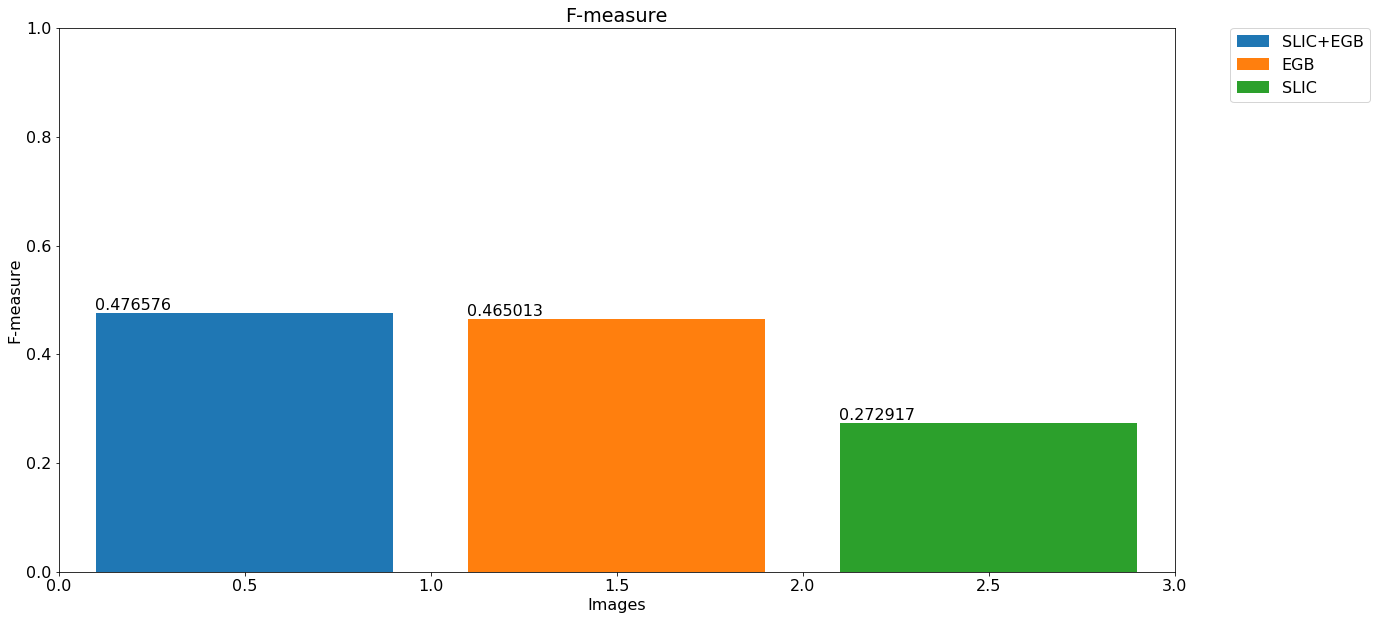

In [99]:
itens = len(fmeasures[0])

#plot curves
plt.figure(figsize=(20,10))

bar1 = plt.bar(0.5, np.max(fmeasures[0]), label='SLIC+EGB') #, marker='o', markersize=5, linewidth=0)
bar2 = plt.bar(1.5, np.max(fmeasures[1]), label='EGB') #, marker='^', markersize=5, linewidth=0)
bar3 = plt.bar(2.5, np.max(fmeasures[2]), label='SLIC') #, marker='s', markersize=5, linewidth=0)

plt.rcParams["font.size"] = 16
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis([0, 3, 0, 1])

for rect in bar1 + bar2 + bar3:
    height = rect.get_height()
    plt.text(rect.get_x()+0.1, height, '%2f' % height, ha='center', va='bottom')

plt.xlabel('Images')
plt.ylabel('F-measure')
plt.title('F-measure')
plt.show()